<a href="https://colab.research.google.com/github/gachet/ad-1-24/blob/main/algo/regresion-lineal-multiple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# regresion lineal multiple


## 1 Dataset description :

- crim : per capita crime rate by town
- zn : proportion of residential land zoned for lots over 25,000 sq.ft.
- indus : proportion of non-retail business acres per town.
- chas : Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).
- nox : nitrogen oxides concentration (parts per 10 million).
- rm : average number of rooms per dwelling.
- age : proportion of owner-occupied units built prior to 1940.
- dis : weighted mean of distances to five Boston employment centres.
- rad : index of accessibility to radial highways.
- tax : full-value property-tax rate per \$10,000.
- ptratio : pupil-teacher ratio by town.
- black : 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town.
- lstat : lower status of the population (percent).
- mdev : median value of owner-occupied homes in \$1000s. (target variable)

ref : [https://www.kaggle.com/c/boston-housing]

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(rc={'figure.figsize':(15,10)})
import matplotlib.pyplot as plt
#from sklearn.datasets import load_boston
import datetime
import math

In [4]:
boston_dataset = pd.read_csv("https://drive.google.com/uc?id=1R0C9Kf7z1Y6ajI0abzxtFXjquTXAgACo")


In [ ]:
boston_dataset.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [5]:
boston_dataset.describe()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


## 2. Feature Selection

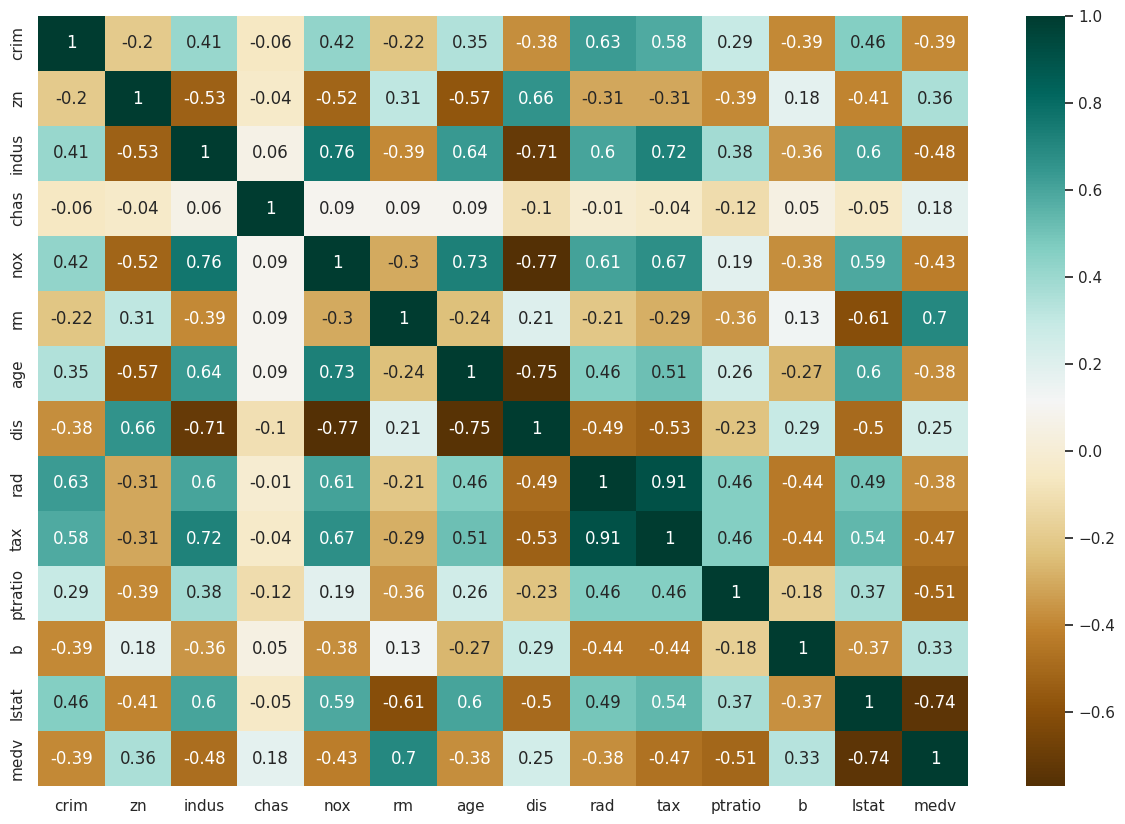

In [6]:
corr_matrix = boston_dataset.corr().round(2)
sns.heatmap(data=corr_matrix, annot=True, cmap="BrBG")
plt.show()

In [8]:
#Relevant features are features highly correlated with our target variable
relevant_features = abs(corr_matrix["medv"])
relevant_features = relevant_features[relevant_features > 0.5]

In [ ]:
relevant_features

RM         0.70
PTRATIO    0.51
LSTAT      0.74
MEDV       1.00
Name: MEDV, dtype: float64

In [9]:
#Because of Least Squares Assumptions (LSA), the independant variables (features) must be uncorrelated with each other
boston_dataset[["rm", "ptratio", "lstat"]].corr().round(2)

,rm,ptratio,lstat
rm,1.00,-0.36,-0.61
ptratio,-0.36,1.00,0.37
lstat,-0.61,0.37,1.00


vemos que RM y LSTAT están altamente correlacionados entre sí, por lo que debemos seleccionar solo uno de ellos. Elegimos aquí tomar el que esté más correlacionado con la variable objetivo, por lo que mantenemos LSTAT.

In [14]:
X = boston_dataset[['ptratio', 'lstat']]
y = boston_dataset['medv']

## 3. Data Preprocessing

In [15]:
def split_data(x, y, ratio, seed=1):
    """split the dataset based on the split ratio."""

    # set seed to have reproducible/consistent results
    np.random.seed(seed)

    # generate random indices
    num_row = len(y)
    indices = np.random.permutation(num_row)
    index_split = int(np.floor(ratio * num_row))
    index_tr = indices[: index_split]
    index_te = indices[index_split:]

    # create split
    x_tr = x.iloc[index_tr]
    x_te = x.iloc[index_te]
    y_tr = y.iloc[index_tr]
    y_te = y.iloc[index_te]
    return x_tr, x_te, y_tr, y_te

def standardize(x):
    """Standardize the original data set."""
    return (x - x.mean(axis=0))/ x.std(axis=0)

def build_model_data(x):
    """Form tX to get regression data in matrix form. tX is X with intercept"""
    num_samples = y.shape[0]
    x["INTERCEPT"] = pd.Series(np.ones(num_samples))
    return x

def prepare_model(X, y, r, s) :
    """Apply all previous helper functions to preprocess data"""

    X_train, X_test, y_train, y_test = split_data(X, y, r, seed=s)

    X_train = standardize(X_train)
    X_train = build_model_data(X_train)

    X_test = standardize(X_test)
    X_test = build_model_data(X_test)

    return X_train, X_test, y_train, y_test

In [21]:
X_train, X_test, y_train, y_test = prepare_model(X, y, 0.9, 1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(455, 3) (51, 3) (455,) (51,)


In [23]:
X_train.head()

,ptratio,lstat,INTERCEPT
307,-0.022042,-0.691284,1.0
343,-0.388403,-0.740350,1.0
47,-0.251018,0.888649,1.0
67,0.206934,-0.611376,1.0
362,0.802271,-0.318381,1.0


## 4. Pandas/Numpy implementation

In [24]:
def mse(e):
    """Compute the mse for the error vector e."""
    return 1/2*np.mean(e**2)

def compute_gradient(y, tx, w):
    """Compute the gradient."""
    err = y - tx.dot(w)
    grad = -tx.T.dot(err) / len(err)
    return grad, err

In [25]:
def gradient_descent(y, tx, initial_w, max_iters, gamma, epsilon = 10e-5):
    """Gradient descent algorithm."""
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    prev = math.inf
    for n_iter in range(max_iters):
        # compute loss, gradient and rmse(actual loss)
        grad, err = compute_gradient(y, tx, w)
        loss = np.sqrt(2 * mse(err))
        # gradient w by descent update
        w = w - gamma * grad
        # store w and loss
        ws.append(w)
        losses.append(loss)
        #Stop earlier if we reached convergence
        if(abs(loss - prev) < epsilon) :
            print("Reached Convergence !")
            break
        prev = loss
        print("Gradient Descent({bi}/{ti}): loss={l}, w0={w0}, w1={w1}, w2={w2}".format(
              bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1], w2=w[2]))

    return losses, ws

In [27]:
# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.7

# Initialization
w_initial = np.array([0, 0, 0])

# Start gradient descent.
start_time = datetime.datetime.now()
gradient_losses, gradient_ws = gradient_descent(y_train, X_train, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

#Get final weights
params = gradient_ws[-1]

#Model is y = w2 + w0*PTRATIO + w1*LSTAT
pred = params[2] + params[0]*X_test.ptratio + params[1]*X_test.lstat

Gradient Descent(0/49): loss=24.614369072457755, w0=-3.2729074300945147, w1=-4.805168507903821, w2=15.944923076923075
Gradient Descent(1/49): loss=9.08788273555628, w0=-3.0051969192238306, w1=-5.399563340550015, w2=20.728400000000004
Gradient Descent(2/49): loss=6.259891262460139, w0=-2.7692768372678818, w1=-5.648694816767803, w2=22.16344307692308
Gradient Descent(3/49): loss=5.924440708887857, w0=-2.633090227297883, w1=-5.785415706856889, w2=22.593956000000006
Gradient Descent(4/49): loss=5.888264728955351, w0=-2.5563272296870085, w1=-5.862200311214182, w2=22.723109876923083
Gradient Descent(5/49): loss=5.883397595999119, w0=-2.5131319572966158, w1=-5.905396457399938, w2=22.761856040000005
Gradient Descent(6/49): loss=5.882452610069755, w0=-2.4888285110623016, w1=-5.929699938971287, w2=22.77347988892308
Gradient Descent(7/49): loss=5.882207127148655, w0=-2.475154506478363, w1=-5.943373944984285, w2=22.776967043600006
Reached Convergence !


<ipython-input-25-0ab4c7cc403c>:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1], w2=w[2]))
<ipython-input-25-0ab4c7cc403c>:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1], w2=w[2]))
<ipython-input-25-0ab4c7cc403c>:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1], w2=w[

In [28]:
#Evaluate performance

exection_time_np = (end_time - start_time).total_seconds()
print("Gradient Descent: execution time={t:.3f} seconds".format(t=exection_time_np))
train_loss_np = gradient_losses[-1]
print("Train loss : {}".format(train_loss_np))
test_loss_np = np.sqrt(2 * mse(y_test - pred))
print("Test loss : {}".format(test_loss_np))

Gradient Descent: execution time=0.020 seconds
Train loss : 5.882134247497131
Test loss : 5.1468062365016936


## 5. Sklearn implementation

In [29]:
from sklearn.linear_model import LinearRegression

In [ ]:
model = LinearRegression()
start_time = datetime.datetime.now()
model.fit(X_train, y_train)
end_time = datetime.datetime.now()

exection_time_sk = (end_time - start_time).total_seconds()
print("Gradient Descent: execution time={t:.3f} seconds".format(t=exection_time_sk))
train_loss_sk = np.sqrt(2 * mse(y_train - model.predict(X_train)))
print("Train loss : {}".format(train_loss_sk))
test_loss_sk = np.sqrt(2 * mse(y_test - model.predict(X_test)))
print("Test loss : {}".format(test_loss_sk))

Gradient Descent: execution time=0.012 seconds
Train loss : 5.882101189744941
Test loss : 5.149021510727107


## 6. Conclusion

**Finally, we got comparable results in terms of performance on train and test set with respect to the RMSE metric. However, sklearn source code uses Least squares method along with other parallel optimization to make its training slightly more efficient. (training in 0.012 seconds with their implementation compared to ours with 0.036 seconds). Furthermore, sklearn implementation leads to smaller and more compact code.**